# graph LR-Harris-icub---探索4个检测器
A[SIFT特征提取] --> B[K-Means生成视觉词汇]
B --> C[图像编码为词袋直方图]
C --> D[SVM训练与分类]

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

import os
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import joblib  # 用于保存模型
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score  # 新增召回率和精确率
from tqdm import tqdm
import pandas as pd

In [2]:
#====================================================
#            Load Dataset(icubworld28)
#TYPE: airplane、automobile、bird、cat、deer、dog、frog、horse、ship、truck
#====================================================

def load_icubworld28(data_dir):
    # 类别映射
    class_names = ['cup','dishwashing-detergent','laundry-detergent',
                   'plate','soap','sponge','sprayer']
    class_to_idx = {name:i for i,name in enumerate(class_names)}
    
    # 加载训练集
    X_train, y_train = [], []
    for cls in class_names:
        cls_dir = Path(data_dir)/'train'/cls
        for img_path in cls_dir.glob('**/*.ppm'):
            img = cv2.imread(str(img_path))
            if img is not None:
                height, width = img.shape[:2]
                new_size = (int(width * 3), int(height * 3))
                img = cv2.resize(img, new_size, interpolation=cv2.INTER_CUBIC)  #等比例放大3倍
                X_train.append(img)
                y_train.append(class_to_idx[cls])
    
    # 加载测试集
    X_test, y_test = [], []
    for cls in class_names:
        cls_dir = Path(data_dir)/'test'/cls
        for img_path in cls_dir.glob('**/*.ppm'):
            img = cv2.imread(str(img_path))
            if img is not None:
                height, width = img.shape[:2]
                new_size = (int(width * 3), int(height * 3))
                img = cv2.resize(img, new_size, interpolation=cv2.INTER_CUBIC)  #等比例放大3倍 
                X_test.append(img)
                y_test.append(class_to_idx[cls])
    
    return np.array(X_train, dtype=object), np.array(y_train), np.array(X_test, dtype=object), np.array(y_test)

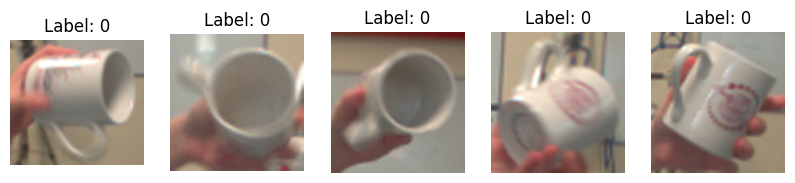

In [3]:
data_dir = 'dataset/iCubWorld28'
train_images, train_labels, test_images, test_labels = load_icubworld28(data_dir)

# ================ 第二部分：可视化检查 ================
def reshape_image(img_array):
    """将BGR图像转换为适合显示的RGB格式"""
    return cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

# 显示示例图像
plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(reshape_image(train_images[i]))
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

In [4]:
#====================================================
#            Harris corner detection----Harris检测可以替换成别的检测方式，但是SIFT 的描述子还是保持不变，后续添加。
# 考虑后续非极大值抑制（non-maximum suppression）的处理，目前会出现很多的圈圈
#====================================================

#====================================================
#            Harris关键点检测器
#====================================================
def detect_harris_keypoints(
    img,
    max_points=100,
    block_size=5,
    ksize=5,
    k=0.04,
    threshold_ratio=0.05,
    min_dist=10
):
    """
    使用 Harris + goodFeaturesToTrack 提取关键点
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(
        gray,
        maxCorners=max_points,
        qualityLevel=threshold_ratio,
        minDistance=min_dist,
        blockSize=block_size,
        useHarrisDetector=True,
        k=k
    )
    keypoints = []
    if corners is not None:
        for c in corners:
            x, y = c.ravel()
            # <-- 这里传第三个位置参数 size
            keypoints.append(cv2.KeyPoint(x, y, ksize*2))
    return keypoints


#====================================================
#            SIFT自带的关键点检测器
#====================================================

def detect_sift_keypoints(img):
    sift = cv2.SIFT_create()
    kps, _ = sift.detectAndCompute(img, None)
    return kps

#====================================================
#            ORB检测器
#====================================================

def detect_orb_keypoints(img, max_keypoints=500):
    """
    使用 ORB 检测关键点（不使用 ORB 描述子，只使用关键点）
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(nfeatures=max_keypoints)
    keypoints = orb.detect(gray, None)
    return keypoints

#====================================================
#            FAST检测器
#====================================================

def detect_fast_keypoints(img, threshold=10, nonmax=True):
    """
    使用 FAST 检测关键点（不使用描述子）
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fast = cv2.FastFeatureDetector_create(threshold=threshold, nonmaxSuppression=nonmax)
    keypoints = fast.detect(gray, None)
    return keypoints

#====================================================
#            计算SIFT描述子
#====================================================

def compute_sift_descriptors(img, keypoints):
    """
    在指定关键点上计算SIFT描述子
    Args:
        img: BGR格式的输入图像
        keypoints: KeyPoint对象列表
    Returns:
        descriptors: 描述子矩阵 (N×128)，若无关键点则返回None
    """
    if len(keypoints) == 0:
        return None
    
    # 初始化SIFT（仅计算描述子，不检测关键点）
    sift = cv2.SIFT_create()
    
    # 计算描述子
    _, descriptors = sift.compute(img, keypoints)
    return descriptors


In [5]:
# === 1. 将各检测器收集到一个字典 ===
# 关键点检测器字典
detector_dict = {
    'harris': detect_harris_keypoints,
    'sift_det': detect_sift_keypoints,
    'orb': detect_orb_keypoints,
    'fast': detect_fast_keypoints}


In [6]:
#====================================================
#      Data preprocessing and feature extraction
#====================================================

def extract_features(images, detector_fn, max_samples=None):
    all_descriptors, valid_indices = [], []
    if max_samples: images = images[:max_samples]
    for idx, img_flat in enumerate(images):
        img = reshape_image(img_flat)
        kps = detector_fn(img) 
        des = compute_sift_descriptors(img, kps)
        if des is not None:
            all_descriptors.extend(des)
            valid_indices.append(idx)
    return np.array(all_descriptors), valid_indices

In [7]:
#====================================================
#      词袋模型构建
#====================================================

from sklearn.cluster import MiniBatchKMeans

def build_codebook(descriptors, k=64):
    """
    构建视觉词汇（Codebook）
    Args:
        descriptors: 所有描述子组成的矩阵 (N×128)
        k: 聚类中心数量
    Returns:
        kmeans: 训练好的K-Means模型
    """
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1024, random_state=42)
    kmeans.fit(descriptors)
    return kmeans


In [8]:

def encode_bow_features(images, codebook, detector_fn):
    X = []
    for img_flat in images:
        img = reshape_image(img_flat)
        kps = detector_fn(img)
        des = compute_sift_descriptors(img, kps)
        if des is None:
            hist = np.zeros(codebook.n_clusters)
        else:
            labels = codebook.predict(des)
            hist = np.bincount(labels, minlength=codebook.n_clusters)
            hist = hist / hist.sum()
        X.append(hist)
    return np.array(X)

In [9]:
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import classification_report, confusion_matrix

# —— 在这里定义 param_grid —— 
param_grid = [
    # 例如我们只测试 RBF 核，C=5，gamma=’auto’
    {'kernel': ['rbf'], 'C': [5], 'gamma': ['auto']},
]

# === 2. 主流程：循环四种检测器 ===
results_summary = {}
for name, det_fn in detector_dict.items():
    print(f"\n=== Running pipeline with {name} detector ===")

    # —— 1. 特征提取，并统计关键点 —— #
    kp_counts = []      # 每张图像提取到的关键点数
    valid_idx = []      # 有描述子的图像索引
    all_descriptors = []

    for idx, img in enumerate(train_images):
        kps = det_fn(img)
        des = compute_sift_descriptors(img, kps)
        n_kp = len(kps) if kps is not None else 0
        kp_counts.append(n_kp)
        if des is not None and len(des)>0:
            all_descriptors.extend(des)
            valid_idx.append(idx)

    avg_kp = np.mean(kp_counts)
    std_kp = np.std(kp_counts)
    valid_ratio = len(valid_idx) / len(train_images)

    print(f"  训练集平均关键点数: {avg_kp:.1f} ± {std_kp:.1f}，有效图像: {len(valid_idx)}/{len(train_images)} ({valid_ratio:.1%})")

    # 重新组装有效的 train/test 子集
    X_tr_imgs = train_images[valid_idx]; y_tr = train_labels[valid_idx]
    # 对测试集做同样统计
    kp_counts_test, valid_test = [], []
    for idx, img in enumerate(test_images):
        kps = det_fn(img)
        kp_counts_test.append(len(kps) if kps is not None else 0)
        des = compute_sift_descriptors(img, kps)
        if des is not None and len(des)>0:
            valid_test.append(idx)
    print(f"  • 测试集平均关键点数: {np.mean(kp_counts_test):.1f}，有效图像: {len(valid_test)}/{len(test_images)}")

    # —— 2. 词典构建 & 聚类质量 —— #
    start = time.time()
    codebook = build_codebook(np.array(all_descriptors), k=300)
    build_time = time.time() - start
    print(f"  • 词典聚类时间: {build_time:.1f}s，Inertia: {codebook.inertia_:.1f}")

    # —— 3. BoW 编码 + TF–IDF + 标准化 —— #
    tfidf = TfidfTransformer(norm='l2')   # 实例化 TF–IDF
    scaler = StandardScaler()              # 实例化标准化

    # 训练集
    X_tr_bow = encode_bow_features(X_tr_imgs, codebook, det_fn)
    X_tr_tfidf = tfidf.fit_transform(X_tr_bow).toarray()
    X_tr = scaler.fit_transform(X_tr_tfidf)

    # 测试集
    X_te_bow = encode_bow_features([test_images[i] for i in valid_test], codebook, det_fn)
    X_te_tfidf = tfidf.transform(X_te_bow).toarray()
    X_te = scaler.transform(X_te_tfidf)

    # —— 4. 训练 & 计时 —— #
    t0 = time.time()
    grid = GridSearchCV(SVC(probability=True), param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    grid.fit(X_tr, y_tr)
    train_time = time.time() - t0
    print(f"  • SVM CV 搜索时间: {train_time:.1f}s，最佳参数: {grid.best_params_}")

    # —— 5. 测试评估 & 报告 —— #
    y_pred = grid.predict(X_te)
    print("  • Test 分类报告：")
    print(classification_report([test_labels[i] for i in valid_test], y_pred))
    print("  • 混淆矩阵：")
    print(confusion_matrix([test_labels[i] for i in valid_test], y_pred))

    # —— 汇总保存 —— #
    results_summary[name] = {
        'avg_kp_train': avg_kp,
        'valid_ratio_train': valid_ratio,
        'inertia': codebook.inertia_,
        'cv_acc': grid.best_score_,
        'test_acc': np.mean(y_pred == [test_labels[i] for i in valid_test]),
        'best_params': grid.best_params_
    }
    


=== Running pipeline with harris detector ===
  训练集平均关键点数: 13.9 ± 8.7，有效图像: 5467/5467 (100.0%)
  • 测试集平均关键点数: 13.9，有效图像: 5550/5550
  • 词典聚类时间: 4.9s，Inertia: 6636018688.0
  • SVM CV 搜索时间: 50.2s，最佳参数: {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}
  • Test 分类报告：
              precision    recall  f1-score   support

           0       0.51      0.54      0.52       799
           1       0.72      0.69      0.71       800
           2       0.50      0.49      0.49       787
           3       0.59      0.64      0.61       793
           4       0.48      0.53      0.50       787
           5       0.43      0.38      0.41       796
           6       0.56      0.51      0.53       788

    accuracy                           0.54      5550
   macro avg       0.54      0.54      0.54      5550
weighted avg       0.54      0.54      0.54      5550

  • 混淆矩阵：
[[431  25  69  30  91  66  87]
 [ 76 556  69  34  11  16  38]
 [ 77  85 388  75  41  46  75]
 [ 44  42  63 506  55  54  29]
 [ 70  18  

In [10]:
# 2.7 最终汇总
print("\n=== Summary ===")
# 1. 转成 DataFrame
df = pd.DataFrame.from_dict(results_summary, orient='index')

# 2. （可选）把列按你想要的顺序排列一下
cols = ['avg_kp_train', 'valid_ratio_train', 'inertia', 'cv_acc', 'test_acc', 'macro_f1', 'best_params']
exist_cols = [c for c in cols if c in df.columns]
df = df[exist_cols]


# 3. 打印表格到屏幕
print(df)

# 4. 导出到 CSV
output_path = 'results_summary_4detection.csv'
df.to_csv(output_path, index=True)  # index=True 会把检测器名写到第一列
print(f"已保存到 {output_path}")


=== Summary ===
          avg_kp_train  valid_ratio_train       inertia    cv_acc  test_acc  \
harris       13.907445           1.000000  6.636019e+09  0.539222  0.540541   
sift_det     36.329065           0.999634  1.564398e+10  0.513632  0.516955   
orb          19.721602           0.785440  6.625797e+09  0.554712  0.556834   
fast         44.350832           0.997805  2.194873e+10  0.548488  0.532138   

                                         best_params  
harris    {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}  
sift_det  {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}  
orb       {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}  
fast      {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}  
已保存到 results_summary_4detection.csv


In [11]:
def enhanced_model_evaluation_svm(model, X_test, y_test, class_names):
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    macro_precision = precision_score(y_test, y_pred, average='macro')
    weighted_precision = precision_score(y_test, y_pred, average='weighted')
    macro_recall = recall_score(y_test, y_pred, average='macro')
    weighted_recall = recall_score(y_test, y_pred, average='weighted')

    print(f'\n{" Enhanced Evaluation ":-^50}')
    print(f'Accuracy:           {acc:.4f}')
    print(f'Macro F1:           {macro_f1:.4f}')
    print(f'Weighted F1:        {weighted_f1:.4f}')
    print(f'Macro Precision:    {macro_precision:.4f}')
    print(f'Weighted Precision: {weighted_precision:.4f}')
    print(f'Macro Recall:       {macro_recall:.4f}')
    print(f'Weighted Recall:    {weighted_recall:.4f}')

    print(f'\n{" Classification Report ":-^50}')
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [12]:
# 加载你上面保存的模型
from joblib import load

best_model = load("sift_bow_best_svm_icub0504_harris.joblib")
class_names = ['cup','dishwashing-detergent','laundry-detergent','plate','soap','sponge','sprayer']
enhanced_model_evaluation_svm(best_model, X_test_scaled, y_test, class_names)

NameError: name 'X_test_scaled' is not defined

In [ ]:
def predict_local_image_sift(image_path, kmeans, svm, class_names):
    """
    参数说明：
    - image_path: 本地图像路径（支持jpg/png等格式）
    - kmeans: 训练好的KMeans模型（用于BoW特征编码）
    - svm: 训练好的SVM分类器（用于最终预测）
    - class_names: 类别名称列表
    """
    try:
        # 1. 读取原始图像
        image = cv2.imread(image_path)
        #image = cv2.resize(image_ori, (32, 32))
        
        if image is None:
            raise FileNotFoundError(f"无法读取文件：{image_path}")

        # 2. 图像灰度转换 + SIFT特征提取
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(gray, None)

        if des is None:
            raise ValueError("无法从图像中提取SIFT特征")

        # 3. 特征编码为BoW直方图
        words = kmeans.predict(des)
        histogram = np.zeros(kmeans.n_clusters)
        for w in words:
            histogram[w] += 1
        histogram = histogram.reshape(1, -1)
        #print("BoW 直方图（未标准化）:", histogram)
        histogram = scaler.transform(histogram)  # 标准化特征
        #print("BoW 直方图（已标准化）:", histogram)

        # 4. SVM预测类别
        predicted_label = svm.predict(histogram)[0]
        probs = svm.predict_proba(histogram)[0]  # 获取所有类别的概率
        #print(f"Prediction probabilities: {probs}")
        
        # 找到最大概率的类别索引
        max_prob_index = np.argmax(probs)
        predicted_class = class_names[max_prob_index]
        confidence = probs[max_prob_index]
        
        # 打印预测类别及置信度
        print(f"Predicted Class: {predicted_class} with Confidence: {confidence:.2%}")
        
        print("SIFT 关键点数量:", len(kp))

        # 5. 可视化结果
        plt.figure(figsize=(15, 6))
        
        # 左侧：绘制SIFT关键点图
        plt.subplot(1, 2, 1)
    
        key_img = cv2.drawKeypoints(
            image, kp, None, 
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # 显示方向和大小的圆圈
        )
        plt.imshow(cv2.cvtColor(key_img, cv2.COLOR_BGR2RGB))
        plt.title(f"SIFT Keypoints (Detected: {len(kp)})")
        plt.axis('off')

        # 右侧：绘制类别置信度直方图
        plt.subplot(1, 2, 2)
        bar_colors = ['skyblue'] * len(class_names)  # 设定天蓝色
        bar_colors[max_prob_index] = 'red'  # 将最大概率的类别设为红色
        plt.barh(class_names, probs, color=bar_colors)
        plt.title(f"Prediction: {predicted_class} ({confidence:.2%})")
        plt.xlabel("Confidence")
        plt.gca().invert_yaxis()  # 反转y轴标签的顺序
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

        return class_names[predicted_label], probs[predicted_label]

    except Exception as e:
        print(f"预测出错：{str(e)}")
        return None, None

In [ ]:
# ====================================================
#               Test Example for SIFT
# ====================================================
# 加载模型
codebook = joblib.load("sift_bow_codebook_icub0501_harris.joblib")
best_model = joblib.load("sift_bow_best_svm_icub0501_harris.joblib")
scaler = joblib.load("sift_bow_scaler_icub0501_harris.joblib")  # 注意：这个变量在你的函数里有使用


class_names = ['cup','dishwashing-detergent','laundry-detergent',
              'plate','soap','sponge','sprayer']

img_path = "dataset/testImg/cup.jpg"

pred_class, confidence = predict_local_image_sift(
    image_path=img_path,
    kmeans=codebook,   # 训练好的KMeans模型
    svm=best_model,         # 训练好的SVM模型
    class_names=class_names
)
